## 1. Import Libraries

In [186]:
from os.path import join
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
pd.options.mode.chained_assignment = None

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor,DMatrix, cv
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
import math

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, mean_squared_error, make_scorer, mean_absolute_error, mean_absolute_percentage_error

## 2. Merge all trip_metrics

In [187]:
#from google.colab import drive
#drive.mount('/content/drive')

In [188]:
# trip_metrics_1 = pd.read_csv("../Yeni dosyalar/trip_metrics_1-6.csv")
# trip_metrics_2 = pd.read_csv("../Yeni dosyalar/trip_metrics_7-12.csv")
# trip_metrics_3 = pd.read_csv("../Yeni dosyalar/trip_metrics_13-18.csv")
# trip_metrics_4 = pd.read_csv("../Yeni dosyalar/trip_metrics_19-24.csv")
# trip_metrics_5 = pd.read_csv("../Yeni dosyalar/trip_metrics_25-30.csv")

# df_list = [trip_metrics_1,trip_metrics_2,trip_metrics_3,trip_metrics_4,trip_metrics_5]
# trips_merged = pd.concat(df_list)
# # trips_merged.to_csv('trips_merged.csv',index=False)



In [189]:
# # if you have all data just use this method
trips_merged = pd.read_csv("trips_merged.csv")
trips_merged

,ID,Energy_Consumption_kWh,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,City_Name,Max_Speed,Min_Speed,...,Max_Altitude-diff,Min_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Characteristic_Acceleration,Kinetic_Intensity,Traffic_Category_Mean
0,vehicle_106_2013-01-02_trip_1,49.808978,2013-01-02 17:03:03,2013-01-02 23:01:16,21493,2.360999,14.095821,New York,85.29502,0.0,...,141.0,-36.0,186.0,0.0,31.439192,-1.630595,2543.015725,0.008343,0.000067,1.987904
1,vehicle_106_2013-01-02_trip_2,0.046400,2013-01-03 00:32:29,2013-01-03 00:33:34,65,0.000000,0.000000,New York,0.00000,0.0,...,0.0,-1.0,30.0,29.0,29.060606,4.000000,2499.651515,-inf,NaN,1.000000
2,vehicle_106_2013-01-02_trip_3,17.837048,2013-01-03 04:38:03,2013-01-03 06:59:37,8494,7.062909,16.664542,New York,48.28020,0.0,...,28.0,-20.0,59.0,0.0,16.777634,1.608240,2530.378340,0.006475,0.000172,2.689935
3,vehicle_106_2013-01-03_trip_1,11.895772,2013-01-03 07:00:39,2013-01-03 08:30:55,5416,5.218145,7.850409,New York,64.37360,0.0,...,38.0,-5.0,92.0,2.0,43.463725,1.625696,2532.115193,-0.057436,-0.000621,3.000000
4,vehicle_106_2013-01-03_trip_2,0.147490,2013-01-03 09:24:15,2013-01-03 09:26:51,156,0.102506,0.004442,New York,3.21868,0.0,...,1.0,-1.0,29.0,25.0,26.573248,2.235669,2495.414013,-2.206256,-9.538746,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61352,vehicle_441_2015-01-10_trip_6,3.652813,2015-01-10 22:13:18,2015-01-10 22:24:12,654,19.997585,3.632895,New Jersey,56.32690,0.0,...,14.0,-6.0,68.0,8.0,33.638168,-8.116031,NaN,-0.105205,-0.000809,1.000000
61353,vehicle_441_2015-01-10_trip_7,0.118821,2015-01-10 22:55:34,2015-01-10 22:57:07,93,1.523737,0.039363,New Jersey,12.87472,0.0,...,23.0,-5.0,44.0,15.0,23.627660,-8.000000,NaN,0.746890,0.197058,1.000000
61354,vehicle_441_2015-01-10_trip_8,17.988823,2015-01-10 23:19:55,2015-01-11 00:05:32,2737,26.445371,20.105828,New Jersey,74.02964,0.0,...,2.0,-9.0,54.0,1.0,27.613587,-7.542001,NaN,0.011211,0.000064,1.000000
61355,vehicle_441_2015-01-11_trip_1,0.299584,2015-01-12 04:58:17,2015-01-12 04:59:53,96,9.938089,0.265016,New Jersey,22.53076,0.0,...,1.0,-1.0,41.0,31.0,36.731959,2.721649,NaN,-0.110937,-0.004504,1.000000


## 3. Feature Enginnering

In [190]:
trips_merged = trips_merged.rename(columns={"City_Name": "State_Name"})

In [191]:
trips_merged.isna().sum()

ID                                0
Energy_Consumption_kWh            0
Start_Time                        0
End_Time                          0
Duration_s                        0
Average_Speed_kmh                 0
Total_Distance_km               667
State_Name                      776
Max_Speed                       667
Min_Speed                       667
Positive_Acceleration_Mean     4995
Positive_Acceleration_Sum         0
Positive_Altitude-diff_Mean    4601
Positive_Altitude-diff_Sum        0
Max_Altitude-diff               709
Min_Altitude-diff               709
Max_Altitude                    691
Min_Altitude                    691
GPS_Altitude_Mean               691
Average_Ambient_Temperature      41
Average_air                    2307
Characteristic_Acceleration    3053
Kinetic_Intensity              4441
Traffic_Category_Mean             0
dtype: int64

In [192]:
trips_merged['Start_Time'] = pd.to_datetime(trips_merged['Start_Time'])
trips_merged['End_Time'] = pd.to_datetime(trips_merged['End_Time'])

trips_merged['Start_Hour'] = trips_merged['Start_Time'].dt.hour
trips_merged['End_Hour'] = trips_merged['End_Time'].dt.hour

In [193]:
# handling the energy consumption values by dropping rows with value 0 and takinbg absolute value to remove negative consumptions
# trips_merged['Energy_Consumption_kWh'] = trips_merged['Energy_Consumption_kWh'] / trips_merged['Total_Distance_km']
trips_merged = trips_merged.rename(columns={"Energy_Consumption_kWh": "Energy_Consumption_kWh/km"})
trips_merged = trips_merged[trips_merged['Energy_Consumption_kWh/km'] >=-50]
# trips_merged['Energy_Consumption_kWh/km'] = trips_merged['Energy_Consumption_kWh/km'].abs()

In [194]:
state_dict = ['内蒙古自治区','Алматы облысы','Pays de la Loire','Comunitat Valenciana','Naâma ⵏⵄⴰⵎⴰ النعامة',
              'Castilla-La Mancha', 'Aragón', '河南省', 'Centre-Val de Loire','Occitanie', 'Salzburg', None, 'Kansas', 'Nevada','Colorado']
trips_merged['State_Name']  = trips_merged['State_Name'].replace(state_dict, 'Unknown')
trips_merged['State_Name'].unique()

array(['New York', 'Unknown', 'Nebraska', 'Indiana', 'Missouri',
       'California', 'Washington', 'Arizona', 'Maryland',
       'District of Columbia', 'New Jersey', 'Illinois', 'Michigan',
       'Wisconsin', 'Virginia'], dtype=object)

## 4. Splitting the data to train test

In [195]:
trips_merged = trips_merged.dropna()

In [196]:
cols_to_keep = ['Duration_s', 'Average_Speed_kmh', 'Max_Speed','Start_Hour','End_Hour',
       'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude',
       'Min_Altitude', 'GPS_Altitude_Mean', 'Average_Ambient_Temperature',
       'Average_air', 'Kinetic_Intensity', 'Traffic_Category_Mean',
       'State_Name','Total_Distance_km']

In [197]:
X = trips_merged[cols_to_keep]
y = trips_merged['Energy_Consumption_kWh/km']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=55, stratify=X['State_Name'])

In [198]:
trips_merged

,ID,Energy_Consumption_kWh/km,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,State_Name,Max_Speed,Min_Speed,...,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Characteristic_Acceleration,Kinetic_Intensity,Traffic_Category_Mean,Start_Hour,End_Hour
0,vehicle_106_2013-01-02_trip_1,49.808978,2013-01-02 17:03:03,2013-01-02 23:01:16,21493,2.360999,14.095821,New York,85.29502,0.0,...,186.0,0.0,31.439192,-1.630595,2543.015725,0.008343,0.000067,1.987904,17,23
2,vehicle_106_2013-01-02_trip_3,17.837048,2013-01-03 04:38:03,2013-01-03 06:59:37,8494,7.062909,16.664542,New York,48.28020,0.0,...,59.0,0.0,16.777634,1.608240,2530.378340,0.006475,0.000172,2.689935,4,6
3,vehicle_106_2013-01-03_trip_1,11.895772,2013-01-03 07:00:39,2013-01-03 08:30:55,5416,5.218145,7.850409,New York,64.37360,0.0,...,92.0,2.0,43.463725,1.625696,2532.115193,-0.057436,-0.000621,3.000000,7,8
4,vehicle_106_2013-01-03_trip_2,0.147490,2013-01-03 09:24:15,2013-01-03 09:26:51,156,0.102506,0.004442,New York,3.21868,0.0,...,29.0,25.0,26.573248,2.235669,2495.414013,-2.206256,-9.538746,3.000000,9,9
5,vehicle_106_2013-01-03_trip_3,20.120323,2013-01-03 12:55:46,2013-01-03 14:33:13,5847,9.185457,14.918713,New York,62.76426,0.0,...,154.0,0.0,41.387996,-0.426129,2551.754104,0.003700,0.000033,2.000000,12,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61206,vehicle_441_2014-12-17_trip_5,0.885249,2014-12-17 20:27:55,2014-12-17 20:32:17,262,12.990984,0.945455,New Jersey,40.23350,0.0,...,51.0,30.0,35.444867,7.000000,6.000000,-0.103654,-0.001678,1.000000,20,20
61207,vehicle_441_2014-12-17_trip_6,0.263241,2014-12-17 20:51:37,2014-12-17 20:53:50,133,7.302080,0.269771,New Jersey,16.09340,0.0,...,54.0,32.0,36.895522,7.074627,6.000000,-0.691696,-0.083466,1.000000,20,20
61208,vehicle_441_2014-12-17_trip_7,8.979697,2014-12-17 22:02:23,2014-12-17 23:08:04,2636,38.616836,28.276106,New Jersey,53.10822,0.0,...,52.0,5.0,20.529389,9.943496,6.000000,0.000555,0.000003,1.000000,22,23
61209,vehicle_441_2014-12-17_trip_8,5.524381,2014-12-17 23:43:54,2014-12-17 23:57:43,829,29.226002,6.730099,New Jersey,69.20162,0.0,...,56.0,3.0,23.185542,11.306024,6.000000,0.004368,0.000022,1.000000,23,23


## Explatory Data Analysis

In [199]:
#merging energy consumption to another df to visualzie the train data better. This df_train will not be used in models
df_train = X_train.copy()
df_train['Energy_Consumption_kWh/km'] = y_train

<Axes: >

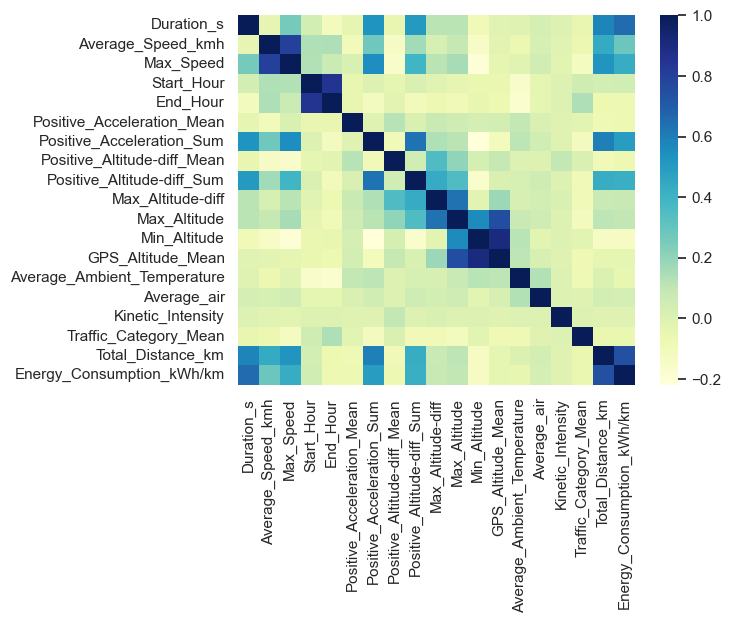

In [200]:
sns.heatmap(df_train.drop(columns=["State_Name"]).corr(), cmap="YlGnBu")

<Axes: >

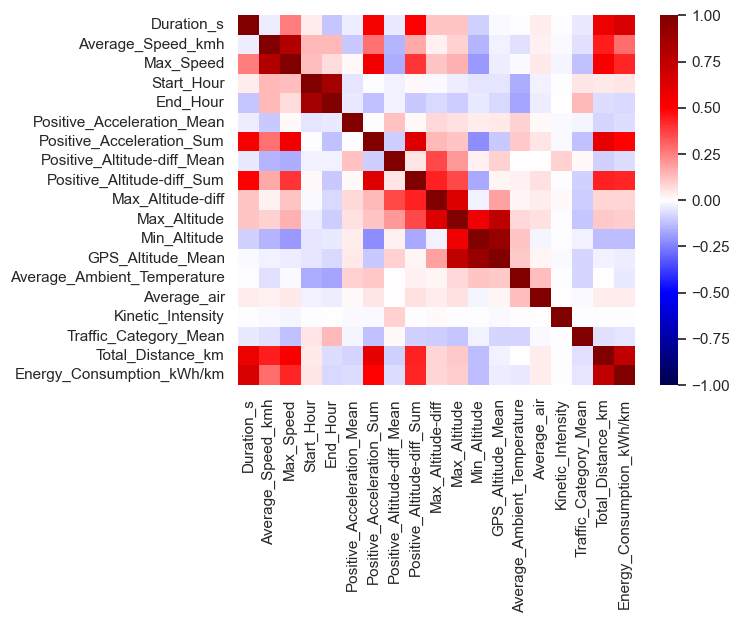

In [201]:
vmin = -1
vmax = 1
cmap = sns.color_palette(["red", "white", "green"])
sns.heatmap(df_train.drop(columns=["State_Name"]).corr(), cmap = "seismic" ,center=0,  fmt=".1f", vmin=vmin, vmax=vmax,)

<Axes: >

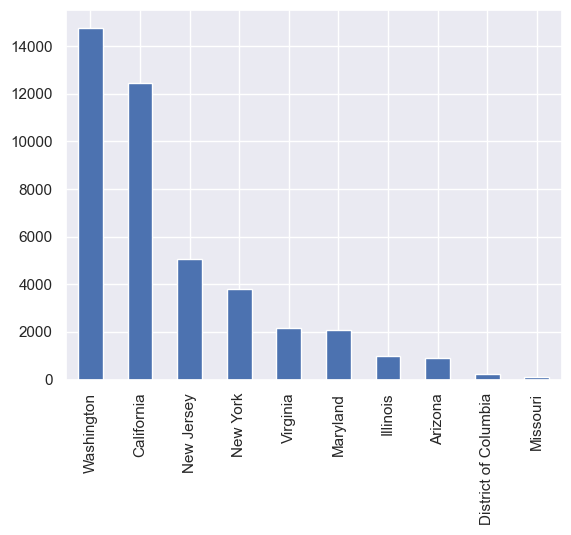

In [202]:
df_train['State_Name'].value_counts().head(10).plot.bar()

<Axes: >

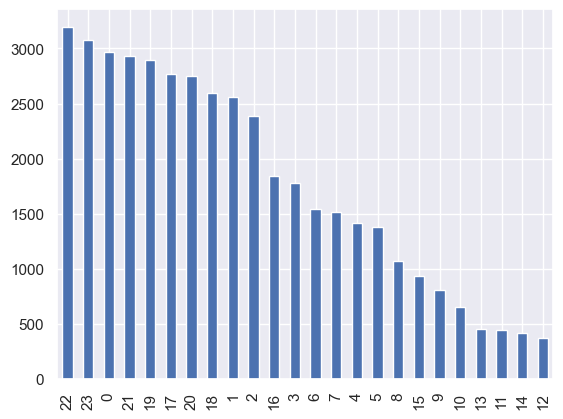

In [203]:
df_train['Start_Hour'].value_counts().plot.bar()

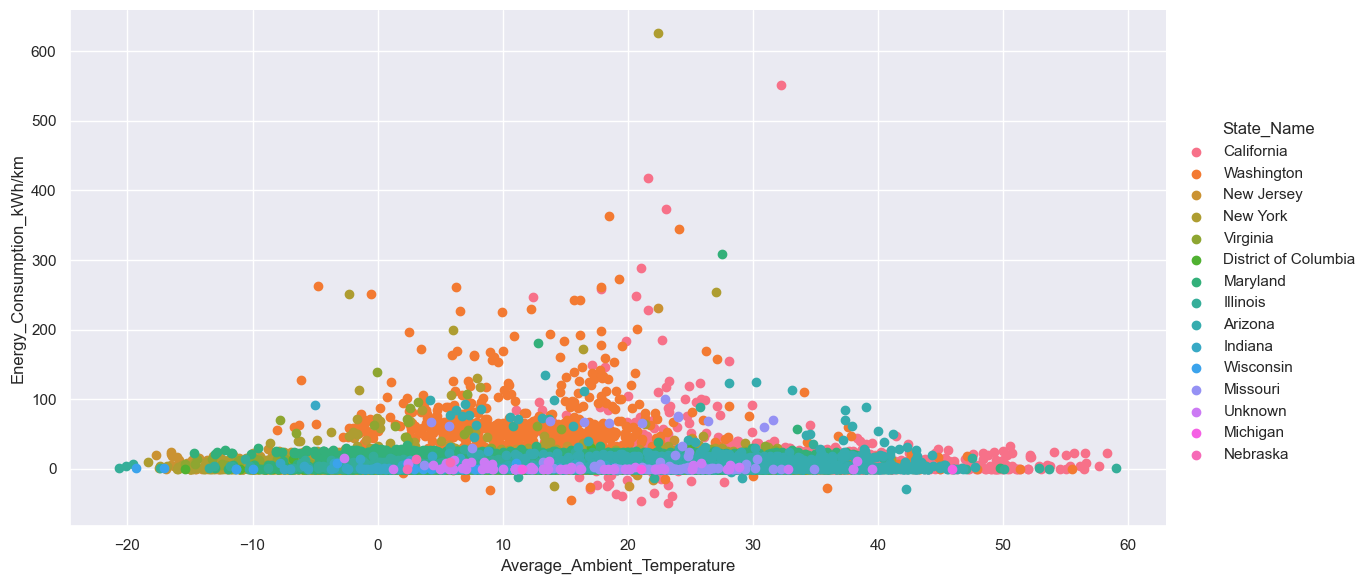

In [204]:
sns.FacetGrid(df_train, hue="State_Name", height=6, aspect=2) \
   .map(plt.scatter, "Average_Ambient_Temperature", "Energy_Consumption_kWh/km") \
   .add_legend()

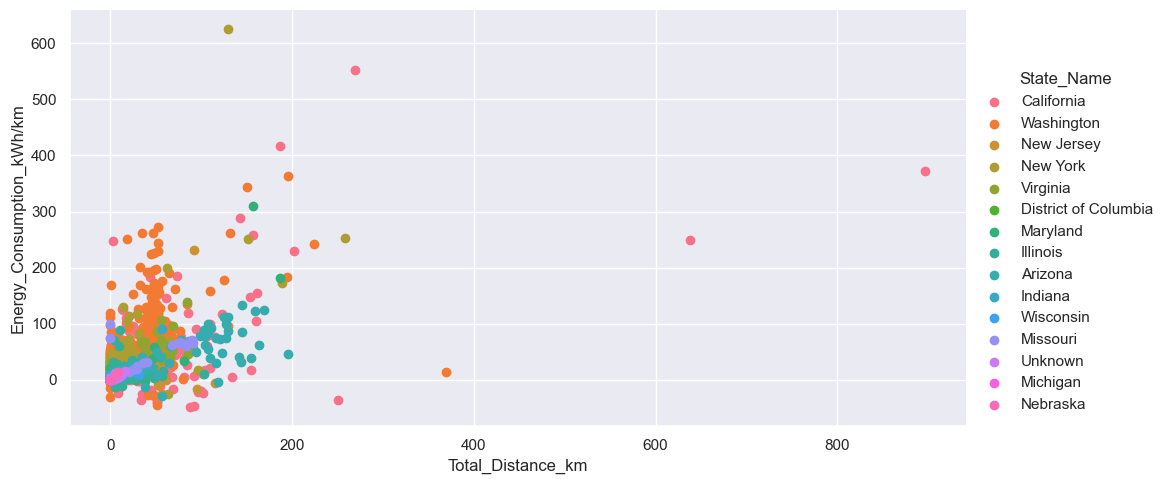

In [205]:
sns.FacetGrid(df_train, hue="State_Name", height=5, aspect=2) \
   .map(plt.scatter, "Total_Distance_km","Energy_Consumption_kWh/km") \
   .add_legend()

In [111]:
df_train.columns

Index(['Duration_s', 'Average_Speed_kmh', 'Max_Speed', 'Start_Hour',
       'End_Hour', 'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude', 'Min_Altitude',
       'GPS_Altitude_Mean', 'Average_Ambient_Temperature', 'Average_air',
       'Kinetic_Intensity', 'Traffic_Category_Mean', 'State_Name',
       'Total_Distance_km', 'Energy_Consumption_kWh/km'],
      dtype='object')

 ## 5. BaseLine Classifier

### 5.1 Baseline for all model

In [206]:
#This part was not in the feature engineering part as we have to startify our train test split according to city names so this part should come after that
X_train = pd.get_dummies(X_train, columns=['State_Name'], prefix="",prefix_sep="") 
X_test = pd.get_dummies(X_test, columns=['State_Name'], prefix="",prefix_sep="") 
# df_train = pd.get_dummies(df_train, columns=['State_Name'], prefix="",prefix_sep="") 

In [208]:
def custom_metric(actual_values,predictions):
    if(actual_values == 0):
        return 0
    error = abs(predictions - actual_values) / actual_values
    if error <= 0.1:
        return 1
    else:
        return 0

In [207]:
def custom_accuracy(actual_values,predictions):
    test = pd.DataFrame(actual_values)
    test['predictions'] = predictions
    test['class'] = test.apply(lambda row: custom_metric(row['Energy_Consumption_kWh/km'],row['predictions']), axis=1)
    accuracy = 0
    if(test.shape[0] > test['class'].value_counts()[0]):
        accuracy = test['class'].value_counts()[1] / test.shape[0]
        
    return accuracy

In [169]:
consumption_mean = y_train.mean()

df_temp = pd.DataFrame(y)
df_temp['baseline'] = consumption_mean

accuracy = custom_accuracy(df_temp['Energy_Consumption_kWh/km'],df_temp['baseline'])
print('Baseline Accuracy is:',accuracy)


Baseline Accuracy is: 0.06551517646618511


### 5.2 Baseline for every State

In [137]:
State_list = df_train['State_Name'].unique()

for x in State_list:
    temp_df = df_train[df_train['State_Name'] == x]
    temp_df['baseline'] = temp_df['Energy_Consumption_kWh/km'].mean() 
    
    accuracy = custom_accuracy(temp_df['Energy_Consumption_kWh/km'],temp_df['baseline'])
        
    print('Baseline Accuracy for',x, 'is:',"%.3f" % accuracy)

Baseline Accuracy for California is: 0.059
Baseline Accuracy for Washington is: 0.068
Baseline Accuracy for New Jersey is: 0.034
Baseline Accuracy for New York is: 0.031
Baseline Accuracy for Virginia is: 0.218
Baseline Accuracy for District of Columbia is: 0.000
Baseline Accuracy for Maryland is: 0.016
Baseline Accuracy for Illinois is: 0.107
Baseline Accuracy for Arizona is: 0.022
Baseline Accuracy for Indiana is: 0.011
Baseline Accuracy for Wisconsin is: 0.000
Baseline Accuracy for Missouri is: 0.018
Baseline Accuracy for Unknown is: 0.014
Baseline Accuracy for Michigan is: 0.000
Baseline Accuracy for Nebraska is: 0.000


## 6. Applying Machine Learning Models

In [253]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
custom_acc = make_scorer(custom_accuracy, greater_is_better=True)

### 6.1. Random Forest 

#### 6.1.1 Random Forest train test split

In [59]:
clf = RandomForestRegressor(n_estimators=500)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(mse)


14965.039252370292


In [60]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
accuracy = custom_accuracy(df_temp['Energy_Consumption_kWh/km'],df_temp['predictions'])
print('Accuracy is:',accuracy)

Accuracy is: 0.5686623012160898


#### 6.1.2 Random Forest Stratified Kfold

In [176]:
#CUSTOM ACCURACY
clf = RandomForestRegressor(n_estimators=700)
cv  = KFold(shuffle=True, random_state=42)

scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=custom_acc)
print(scores)
print(f'Scores mean: {np.mean(scores):.4f}')

[0.57391813 0.57883041 0.56982456 0.56666667 0.57777778]
Scores mean: 0.5734


In [ ]:
#MEAN SQUARED ERROR
clf = RandomForestRegressor(n_estimators=700)
cv  = KFold(shuffle=True, random_state=42)

scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=mse)
print(scores)
print(f'Scores mean: {np.mean(scores):.4f}')

### 6.2 XGBoost

#### 6.1.1 XGBoost train test split

In [224]:
params = {
    'learning_rate': [0.1]
    # 'max_depth': [9],
    # 'subsample':[0.9],
    # 'colsample_bytree':[0.9],
    # 'gamma':[0.3]
}

# create an XGB Boost instance
xgb_reg = XGBRegressor()

# searching the model
XGB_Model= GridSearchCV(estimator = xgb_reg, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=mse)


In [102]:
XGB_Model.fit(X_train, y_train)
predictions = XGB_Model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(mse)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
59.35426831705598


In [ ]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['Energy_Consumption_kWh/km'],row['predictions']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Accuracy is:',accuracy)

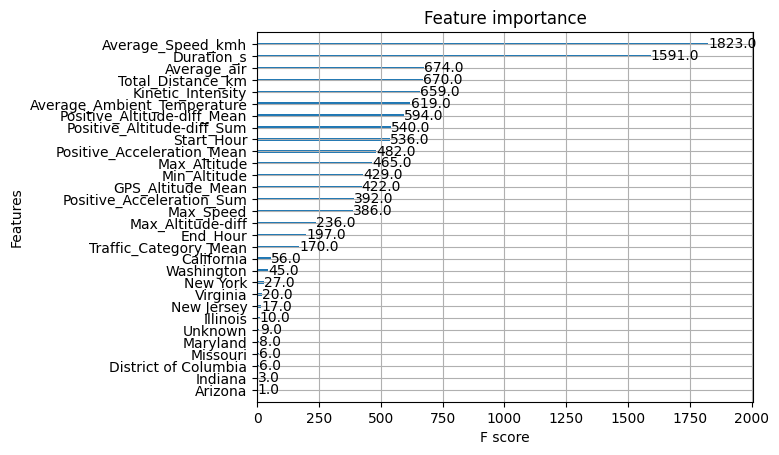

In [65]:
from xgboost import plot_importance
plot_importance(XGB_Model.best_estimator_)
plt.show()

#### 6.1.2 XGBoost Kfold

In [236]:
xgb_reg = XGBRegressor(learning_rate =0.1,
 n_estimators=400,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

# n_estimators: 1000=0.47, 900=0.4657, 800=0.4575,700= , 600= , 500= , 400=

In [237]:
cv  = KFold(shuffle=True, random_state=42)

scores = cross_val_score(xgb_reg, X_train, y_train, cv=cv, scoring=custom_acc)
print(scores)
print(f'Scores mean: {np.mean(scores):.4f}')

[0.41883041 0.4194152  0.41204678 0.40292398 0.41473684]
Scores mean: 0.4136


### 6.4 Extra Trees

#### 6.1.1 Extra Trees Train Test Split

In [254]:
clf = ExtraTreesRegressor()
parameters = {
    'n_estimators': [700,1000],
    # 'max_depth': [34],
    # 'min_samples_split': [ 21]
}
clf = GridSearchCV(clf, parameters, cv=5, verbose=True, scoring=mse)
clf.fit(X_train, y_train)
clf.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'n_estimators': 700}

In [256]:
predictions = clf.predict(X_test)
mse_s = mean_squared_error(y_test, predictions)
print('Mse:',mse_s)
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()

accuracy = custom_accuracy(df_temp['Energy_Consumption_kWh/km'],df_temp['predictions'])
print('Accuracy:',accuracy)

Mse: 52.52781078796234
Accuracy: 0.5994573353293413


#### 6.1.2 Extra Trees Stratified Kfold

In [245]:
#CUSTOM ACCURACY
clf = ExtraTreesRegressor(n_estimators=700)
cv  = KFold(shuffle=True, random_state=42)

scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=custom_acc)
print(scores)
print(f'Scores mean: {np.mean(scores):.4f}')

[0.59426901 0.60187135 0.59017544 0.58818713 0.59111111]
Scores mean: 0.5931
